# PROPHET 사용법

In [33]:
# 패키지 버전 확인
from fbprophet import Prophet #prophet 모델링에 필요한 패키지

!pip show fbprophet

Name: fbprophet
Version: 0.7.1
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: Sean J. Taylor <sjtz@pm.me>, Ben Letham <bletham@fb.com>
Author-email: sjtz@pm.me
License: MIT
Location: c:\users\test\anaconda3\lib\site-packages
Requires: python-dateutil, tqdm, Cython, matplotlib, numpy, cmdstanpy, holidays, LunarCalendar, setuptools-git, convertdate, pandas, pystan
Required-by: 


===============================================
# PROPHET 모형
===============================================

Facebook 에서 설명가능하고 사용하기 쉬운 user friendly 한 모형으로써 2018년에 제시됨.

후속 연구로써, AR-NET, Neural Prophet 등을 차례로 제시함. 각 논문들은 아래와 같음.

"Forecasting at Scale", (2018) --- Prophet 모형

"AR-NET: A SIMPLE AUTO-REGRESSION NEURAL NETWORK FOR TIME SERIES", (2019) --- AR-Net 모형

"NeuralProphet: Explainable Forecasting at Scale", (2021) --- Neural Prophet 모형

===============================================

### Prophet 모형은 아래와 같이 구성된다.
$y_{t} = g(t) + s(t) + h(t) + \epsilon_{t}$.

g(t) : 트렌드 함수 (linear, sigmoid)

s(t) : 주기, 계절적 효과 (주간, 연간 등)

h(t) : 휴일(holiday)의 효과

$\epsilon_{t}$ : 모델로 설명이 안되는 shock


# 1. PROPHET 모델링 (일간)

기본적으로 Prophet 모형은 일간 예측을 가정으로 설계되어있다. 하지만 이 framework를 그대로 가지고 월간 예측에 적용가능하다.
먼저, 일간 예측을 진행해보자.

In [7]:
train = df.reset_index()
train.columns = ['ds','y']

In [8]:
train.head() #일간 데이터

,ds,y
0,1989-01-03,3151.9
1,1989-01-04,3166.9
2,1989-01-05,3203.5
3,1989-01-06,3124.4
4,1989-01-09,3145.3


#### &uarr; Prophet 모델링에 사용하기 위해서 데이터프레임의 column 명을 'ds' 와 'y'로 바꿔주어야함.

In [9]:
# holiday 날짜 설정
holiday1 = pd.DataFrame({
'holiday': 'holiday1',
'ds': pd.to_datetime([str(i)+'-01-01' for i in range(1989,2023)]),
'lower_window': -1,
'upper_window': 1,
})

holiday2 = pd.DataFrame({
    'holiday': 'holiday2',
    'ds': pd.to_datetime([str(i)+'-12-25' for i in range(1989,2023)]),
    'lower_window': -1,
    'upper_window': 1,
  })
holidays = pd.concat((holiday1, holiday2))
holidays.head(3)

,holiday,ds,lower_window,upper_window
0,holiday1,1989-01-01,-1,1
1,holiday1,1990-01-01,-1,1
2,holiday1,1991-01-01,-1,1


#### &uarr; Prophet 모형은 holiday 반영이 가능하다. 위에서는 holiday1, holiday2를 임의로 설정해보았다. lower_window와 upper_window는 holiday 근처 몇일을 holiday 영향을 받는 기간으로 볼지 결정. 이 예시에서는 앞뒤 1일간을 holiday 영향 기간으로 설정.

In [10]:
prophet = Prophet(
# trend
growth = 'linear',
changepoints = None,
changepoint_range = 0.9, 
changepoint_prior_scale= 0.9, 
# seasonality
seasonality_prior_scale=10,
weekly_seasonality=False,
yearly_seasonality=False,
daily_seasonality=False,
seasonality_mode='additive',
#holiday
holidays=holidays,
holidays_prior_scale = 0.5,
#interval_width
interval_width = 0.95,
#mcmc
mcmc_samples = 100
)
prophet.add_seasonality(name='monthly',period=30.5,fourier_order=5) 
prophet.fit(train) 

### &uarr;  Prophet() 함수에서 각 인자들의 뜻은 아래와 같다.

growth : trend의 함수를 정의. 선형(linear) 또는 비선형(logistic) 중 선택 가능

changepoints : change point들을 직접 설정가능함. 리스트 형태. ex) changepoints = ['2020-01-01']

changepoint_range : 전체 기간 중 change point가 발생할 범위 (0~1 사이의 값, 즉 전체의 몇퍼센트에서 change point가 발생할 수 있는지 설정)

changepoint_prior_scale : change point가 발생하는 빈도의 정도 (0~1 사이의 값으로 조정, 클수록 모델이 유연해지므로 overfitting의 위험 존재)

seasonality_prior_scale : 계절성의 정도를 조절하는 파라미터

weekly_seasonality : 주간 계절성 반영 유무 (True/False)

daily_seasonality : 일간 계절성 반영 유무 (True/False)

seasonality_mode : 계절성을 트렌드에 더한 형태로 표현할지, 곱한 형태로 표현할지 결정 ('additive', 'multiplicative')

holidays : holiday 정보가 들어있는 데이터프레임

holidays_prior_scale : holiday 효과를 얼마나 반영할지 조절. (클수록 holiday의 효과가 강함)

interval_width : bayesian credible interval 의 신뢰도를 조정.

mcmc_samples : 0일 경우 MAP 추정법을, 0보다 클 경우 Full Bayesian Inference(Monte Carlo Markov Chain)을 진행함. MCMC 과정은 속도가 오래걸리므로 정확 Uncertainty 측정을 위해서는 0보다 큰값을, 예측만을 위해서는 0을 지정. MCMC 횟수를 더 많이 할 수록 더 정확한 추론이 가능함. 하지만 시간이 너무 오래걸린다는 단점.


prophet.add_seasonality(name=a,period=b,fourier_order=c) : 계절성의 주기를 b로 하고 푸리에 차수는 c로 하는 계절성을 반영. 본 계절성의 이름을 a로 명명. (푸리에 차수가 클수록 유연)


prophet.fit(df) : 데이터프레임 df을 받아서 위에서 정의한 prophet 모델링을 진행. (단 df의 column 명은 'ds'와 'y' 이어야함)


### -미래 예측 (일간)

In [11]:
future = prophet.make_future_dataframe(periods=12) #향후 12일 예측
forecast = prophet.predict(future)
forecasted = list(np.array(forecast['yhat'].tail(12)))
print(forecasted) #예측값들 출력

[9999.694755660392, 10009.724556789872, 10012.285711003375, 10006.849097194812, 9999.025089798626, 9996.515226161364, 10003.147309109165, 10015.781593987915, 10026.69464282741, 10029.59833015677, 10024.481450814936, 10017.483160558411]


### -모델 시각화 (일간)

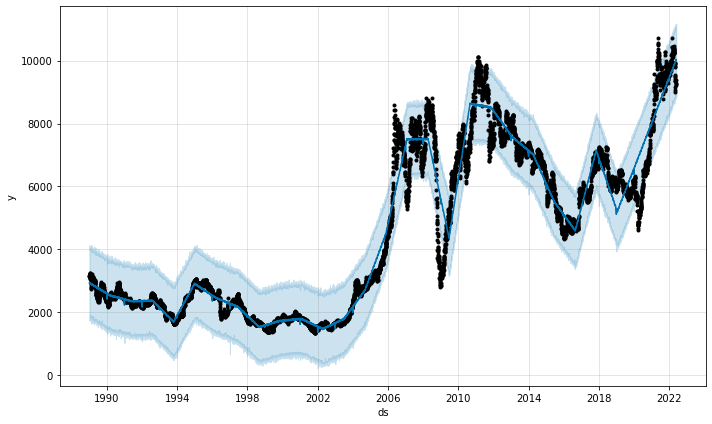

In [12]:
fig1 = prophet.plot(forecast)

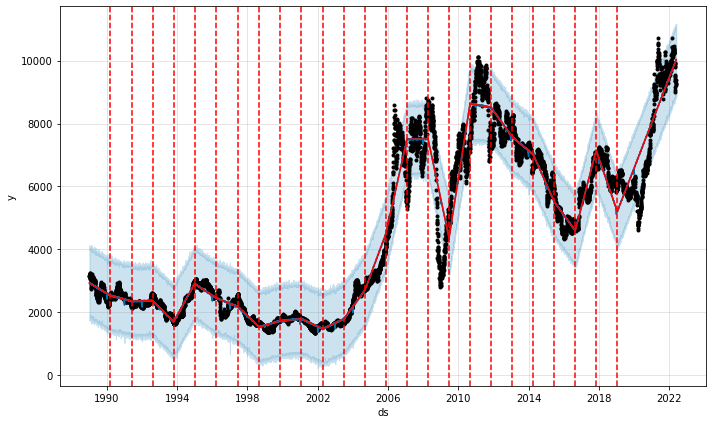

In [13]:
 from fbprophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

#### &uarr; Change point들을 시각화

<AxesSubplot:>

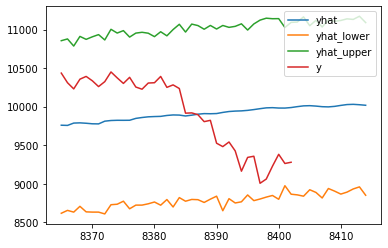

In [14]:
uncertainty_df = forecast.tail(50)
uncertainty_df = uncertainty_df[['yhat','yhat_lower','yhat_upper']]
uncertainty_df['y'] = train.tail(50)['y']
uncertainty_df.plot()

#### &uarr; 최근 50일간 가격 실제값(빨간선), 예측값(파란선), 예측값 상한(초록선), 예측값 하한(주황선)을 나타냄. 단, 예측값 상한과 하한의 신뢰도는 95%임.

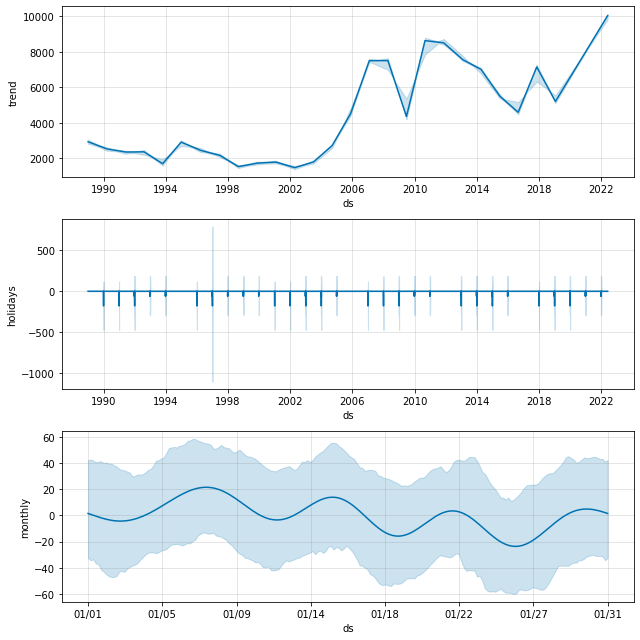

In [15]:
fig3 = prophet.plot_components(forecast)

#### &uarr; Prophet 모형이 트렌드, holiday, seasonality를 어떻게 잡아내고 있는지를 시각화함. holiday를 보면 위에서 임의 지정한 holiday (매년 1월 1일, 12월 25일)와 전후 1일간의 가격은 내려가는 효과가 있음을 확인할 수 있음.

# 2. PROPHET 모델링 (월간)

월간 예측을 하기 위해서 먼저, 데이터를 월간 평균으로 resampling 하자.

In [18]:
train.head() #월간 데이터

,ds,y
0,1989-01-01,3170.352381
1,1989-02-01,2910.155000
2,1989-03-01,3045.557143
3,1989-04-01,2963.680000
4,1989-05-01,2708.119048


In [19]:
import datetime
from dateutil.relativedelta import relativedelta

def to_date(date_in, date_form = "%Y-%m-%d"):
    """
    datetime.datetime()이나 str을 datetime.date()화
    """
    if type(date_in) == str and len(date_in.split("-")) == 3:
        return(datetime.datetime.strptime(date_in, date_form).date())
    else:
        try:
            return(date_in.date())
        except:
            return(date_in)

train['ds'] = pd.Series([to_date('2000-01-01') + relativedelta(days=x) for x in range(len(train))])
train.head(10)

,ds,y
0,2000-01-01,3170.352381
1,2000-01-02,2910.155000
2,2000-01-03,3045.557143
3,2000-01-04,2963.680000
4,2000-01-05,2708.119048
5,2000-01-06,2493.854545
6,2000-01-07,2434.495238
7,2000-01-08,2694.845455
8,2000-01-09,2830.785714
9,2000-01-10,2798.172727


#### &uarr; 월간 시계열을 prophet 패키지가 일간 시계열로 인식하도록 날짜 형식만 바꿔주자. 이는 시계열의 순서를 흩트려 놓지 않는다는 점에서 prophet모형의 기본 원리에 벗어나지 않는다. 단지 인덱스만 "월간 인덱스"에서 "일간 인덱스"로 변환한 것이므로 모델링에는 영향이 없다고 볼 수 있다. 또한 Prophet 모델링에 사용하기 위해서 데이터프레임의 column 명을 'ds' 와 'y'로 바꿔주어야함.

In [20]:
prophet = Prophet(
# trend
growth = 'linear',
changepoints = None,
changepoint_range = 0.9, 
changepoint_prior_scale= 0.9, 
# seasonality
seasonality_prior_scale=10,
weekly_seasonality=False,
yearly_seasonality=False,
daily_seasonality=False,
seasonality_mode='additive',
#holiday
#holidays=holidays,
#holidays_prior_scale = 0.5,
#interval_width
interval_width = 0.95,
#mcmc
mcmc_samples = 100
)
prophet.add_seasonality(name='year',period=12,fourier_order=5) 
prophet.fit(train) 

#### &uarr; 월간 데이터이므로 12개 단위를 하나의 seasonality로 설정. 이때, seasonality의 이름은 'year'로 명명. 즉, 주기가 12인 seasoanlity를 반영. 월간 예측임을 감안하여 holiday효과는 배제하였음. 모델 파라미터 설명은 PROPHET 모델링(일간)과 동일

### -미래 예측 (월간)

In [21]:
future = prophet.make_future_dataframe(periods=12) #향후 12개월 예측
forecast = prophet.predict(future)
forecasted = list(np.array(forecast['yhat'].tail(12)))
print(forecasted) #예측값들 출력

[9785.151889654959, 9944.67437033591, 10046.33282658528, 10139.31222473443, 10162.536911278754, 10202.210056661968, 10327.257535093308, 10437.857416987414, 10595.66034843213, 10744.524281296188, 10926.669454899506, 10985.671076997454]


### -모델 시각화 (월간)

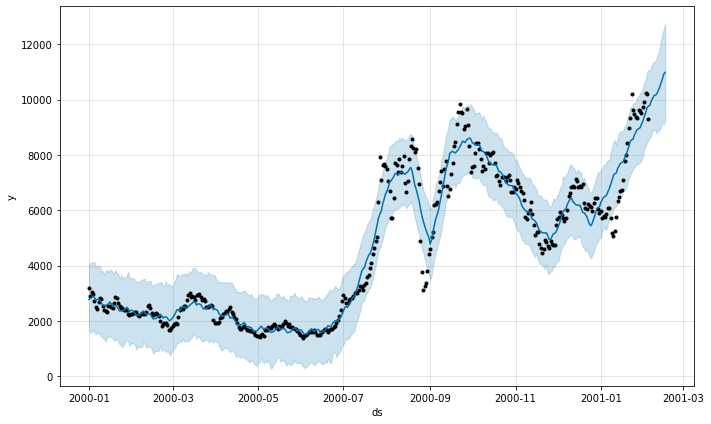

In [22]:
fig1 = prophet.plot(forecast)

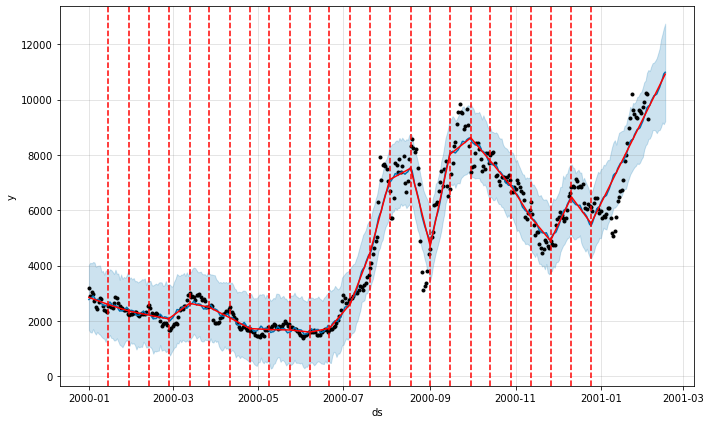

In [23]:
 from fbprophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

#### &uarr; Change point들을 시각화

<AxesSubplot:>

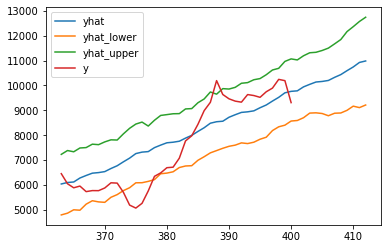

In [24]:
uncertainty_df = forecast.tail(50)
uncertainty_df = uncertainty_df[['yhat','yhat_lower','yhat_upper']]
uncertainty_df['y'] = train.tail(50)['y']
uncertainty_df.plot()

#### &uarr; 최근 50개월간 가격 실제값(빨간선), 예측값(파란선), 예측값 상한(초록선), 예측값 하한(주황선)을 나타냄. 단, 예측값 상한과 하한의 신뢰도는 95%임.

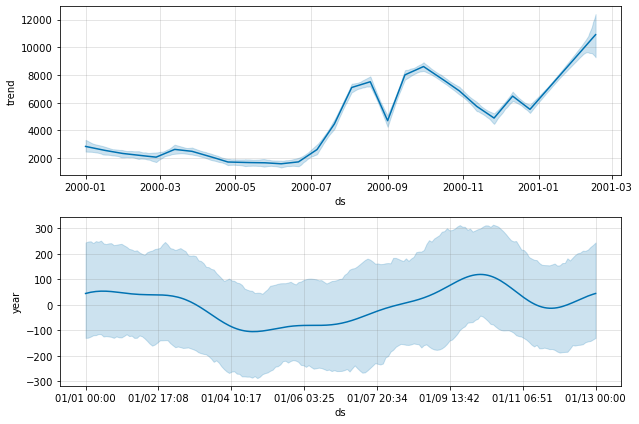

In [25]:
fig3 = prophet.plot_components(forecast)

#### &uarr; Prophet 모형이 트렌드,  seasonality(주기 12)를 어떻게 잡아내고 있는지를 시각화함.

# 3. PROPHET 모델링의 장단점

#### 장점: 시계열이 Trend, 계절효과(seasonality), 휴일효과(holidays)로 이루어져 있다는 직관적인 가정으로 모델링을 하므로 이해하기 쉬우며 설명이 가능함.

#### 단점 : 베이지안 방법론의 특성상 시간이 오래걸릴 수 있음.(pystan 사용) 또한 AR과 같은 확률적인 종속성을 가정하지 않으므로 다소 투박하게 예측이 됨.(overshooting의 위험이 있음)